---
title: Policy Gradient Methods
description: Exploring the intuition of Policy Gradient Methods in Deep Reinforcement Learning through End-to-End Example.
imgUrl: ./src/notebooks/drl-policy-gradient.png
imgAlt: drl-policy-gradient
imgSize: '(min-width: 30em) 50vw, 100vw'
pictureClass: grid-column-full
imgClass: img-full

date: "2022-04-10"
tags:
  - DeepRL
  - PolicyGradient
  - HW2Berkley
layout: layouts/post.njk


use_katex: true
use_prism: true
---

In [1]:
#@title Installl required librairies

!apt install -y xvfb &> /dev/null
%pip install pytorch-lightning==1.9.3 gym-notebook-wrapper==1.3.3 mujoco==2.2.0 gym==0.25.2 "gym[box2d]" pyyaml &> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Import useful librairies

import gym
import gnwrapper
import torch
import yaml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from glob import glob
from tqdm.auto import trange, tqdm
from torch import optim, nn, utils

gnwrapper._video_callable_key = 'step_trigger'

# ignore: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
import warnings
warnings.filterwarnings("ignore")

%pip install mediapy &> /dev/null # we install this package after having imported our required packages as it has a version conflict with pytorch_lightning on PIL requirement
import mediapy as media

/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


Note: you may need to restart the kernel to use updated packages.


# Defining the Problem before Writing Code

Assuming that you have a basic understanding of (deep) reinforcement learning, we can dive into the problem at hand. If you're not familiar with the concepts, I suggest reading [this post](https://lilianweng.github.io/posts/2018-02-19-rl-overview/#sarsa-on-policy-td-control) before proceeding.

## A Quick Recap of the Setup

We have an agent that interacts with an environment, taking actions $a_t$ at state $s_t$ using a policy $\pi(a_t | s_t)$. This policy determines the probability of taking action $a_t$ at state $s_t$. The agent then receives a reward $r(s_t, a_t)$, which is also referred to as $r_t$, along with a new state $s_{t+1}$. The ultimate goal of the agent is to maximize the total reward, i.e., $\sum_t r(s_t, a_t)$.

In deep reinforcement learning, we use a parametrized policy network, denoted by $\theta$, to represent $\pi$.


## Formulating the Objective Function in Policy Gradient Methods

The more natural way to formulate the objective function is to maximize the expected reward of following the policy $\pi_\theta$. For this purpose, we define an objective function $J$ that maximizes the expected reward with respect to the policy parameters $\theta$:

$$
\begin{aligned}
J(\theta) &:= \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T r(s_t, a_t) \right] && \text{where } \tau = (s_0, a_0, s_1, a_1, \dots, s_T, a_T) \\
\end{aligned}
$$

However, it's often not possible to compute this expectation as the transition probabilities $p(s_{t+1} | s_t, a_t)$ and the reward function $r(s_t, a_t)$ are typically **unknown**. Instead, we can approximate $J(\theta)$ by running $N$ simulations using our policy $\pi_\theta$ and computing the average reward as:

$$
\begin{aligned}
J(\theta) & \approx \frac{1}{N} \sum_{i=0}^N \sum_{t=0}^T r(s^{(i)}_t, a^{(i)}_t) && \text{(Monte Carlo estimate)}
\end{aligned}
$$

Where the $i^{th}$ trajectory $\tau^{(i)} = (s_0^{(i)}, a_0^{(i)}, s_1^{(i)}, a_1^{(i)}, \dots, s_T^{(i)}, a_T^{(i)})$.

# Formulating the Objective Function in Policy Gradient Methods

To maximize the expected reward of following a policy, we can formulate the objective function as $J(\theta)$, where $\theta$ represents the policy parameters. 

The objective function $J(\theta)$ can be defined as:

$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T r(s_t, a_t) \right],
$$

where $\tau = (s_0, a_0, s_1, a_1, \dots, s_T, a_T)$ is a trajectory, and $\pi_\theta$ represents the policy. 

However, it's often not possible to compute this expectation as the transition probabilities $p(s_{t+1} | s_t, a_t)$ and the reward function $r(s_t, a_t)$ are typically unknown. Instead, we can approximate $J(\theta)$ by sampling $N$ trajectories $\tau$ from $\pi_\theta$ and computing the average reward as:

$$
J(\theta) \approx \frac{1}{N} \sum_{i=0}^N \sum_{t=0}^T r(s_t, a_t) \quad \text{(Monte Carlo estimate)}
$$


## The idea behind policy gradient

The idea behind this method is to run several simulations using a parametrized policy $\pi_\theta$  and update the parameters $\theta$ to maximize the "good" decisions and minimize the "bad" decisions. The "good" and "bad" decisions are defined by the reward function $r$.

The more natural way to formulate the objective function is by trying to maximize the expected reward of the policy $\pi_\theta$. Let $J$ be the objective function which aims to maximize with respect to the policy parameters $\theta$:

$$
\begin{aligned}
J(\theta) &:= \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T r(s_t, a_t) \right] && \text{where } \tau = (s_0, a_0, s_1, a_1, \dots, s_T, a_T) \\
\end{aligned}
$$

Unfortunately, **we cannot compute this expectation** as we usually do not know the transition probabilities $p(s_{t+1} | s_t, a_t)$ and the reward function $r(s_t, a_t)$. We can only sample $N$ trajectories $\tau$ from the policy $\pi_\theta$ and compute the average reward:

$$
\begin{aligned}
J(\theta) & \approx \frac{1}{N} \sum_{i=0}^N \sum_{t=0}^T r(s_t, a_t) && \text{(Monte Carlo estimate)}
\end{aligned}
$$

## *Agent* class

It will be used to **train a policy network** and a **baseline network** (if required) and make predictions of actions and values based on observations with respect to these networks.

In [3]:
class Agent(pl.LightningModule):
    def __init__(self, obs_dim, act_dim, use_baseline=False):
        super().__init__()
        self.use_baseline = use_baseline
        self.baseline_nn = nn.Sequential(nn.Linear(obs_dim, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, act_dim))
        self.policy_nn = nn.Sequential(nn.Linear(obs_dim, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64, act_dim))
        self.policy_logstd = nn.Parameter(torch.zeros(act_dim, dtype=torch.float32))

    def _policy_forward(self, obs):
        mean = self.policy_nn(obs)
        scale_tril = torch.diag(torch.exp(self.policy_logstd))
        return torch.distributions.MultivariateNormal(mean, scale_tril=scale_tril)

    def _baseline_forward(self, obs):
        return self.baseline_nn(obs).squeeze()

    def _policy_loss(self, batch):
        obs, acts, advs, q_vals, dones, rewards = batch
        pred_distrib = self._policy_forward(obs)
        loss = -(pred_distrib.log_prob(acts) * advs).sum()
        return loss

    def _baseline_loss(self, batch):
        obs, acts, advs, q_vals, dones, rewards = batch
        pred_val = self._baseline_forward(obs)
        loss = nn.functional.mse_loss(pred_val, q_vals)
        return loss

    # public functions:
    def get_action(self, obs):
        with torch.no_grad():
            return self._policy_forward(torch.Tensor(obs)).sample().numpy()

    def predict_values(self, obs):
        with torch.no_grad():
            return self._baseline_forward(torch.Tensor(obs)).detach().numpy()

In [ ]:
class AgentPlt(Agent):
    def __init__(self, obs_dim, act_dim, use_baseline, lr=0.02):
        self.save_hyperparameters()
        super().__init__(obs_dim, act_dim, use_baseline)
        self.lr = lr


    # pytorch-lighting required functions:
    def training_step(self, batch, batch_idx, optimizer_idx=0):
        if optimizer_idx == 0:
            loss = self._policy_loss(batch)
        else:
            loss = self._baseline_loss(batch)
        return loss

    def configure_optimizers(self):
        policy_opt = optim.Adam([self.policy_logstd, *self.policy_nn.parameters()], lr=self.lr)
        baseline_opt = optim.Adam(self.baseline_nn.parameters(), lr=self.lr)
        if self.use_baseline:
            return [policy_opt, baseline_opt]
        else:
            return policy_opt

## *Env* class

It will be utilized to **run a single or multiple simulations** based on an agent's behavior.

In [ ]:
class Env:
    def __init__(self, env_name='CartPole-v1', render=False, max_simulation_length=1000, dirpath=None):
        self.env_name = env_name
        self.max_simulation_length = max_simulation_length
        if render:
            self.env = gnwrapper.Monitor(gym.make(env_name, render_mode='rgb_array'), directory=dirpath or env_name, video_callable=lambda _: True)
        else:
            self.env = gym.make(env_name)
        assert isinstance(self.env.action_space, gym.spaces.Box), 'Only continuous environment is supported.'
        self.obs_dim = self.env.observation_space.shape[0]
        self.act_dim = self.env.action_space.shape[0]

    def run_agent(self, agent):
        traj = []
        obs = self.env.reset()
        for _ in range(self.max_simulation_length):
            action = agent.get_action(obs)
            next_obs, reward, done, info = self.env.step(action)
            traj.append([obs, action, reward, done])
            obs = next_obs
            if done:
                break
        traj[-1][-1] = True # could be set to False if max_simulation_length is reached
        self.env.close()
        return traj

## *On Policy Dataset* class

This class will be used to create **a fresh dataset** at each epoch by running a simulation based with the **more recent agent**. 


In [ ]:
class OnPolicyDataset(torch.utils.data.IterableDataset):
    def __init__(self, agent, env, use_advantage=False, discount_factor=1, dataset_length=1000, batch_size=None):
        super().__init__()
        self.agent = agent
        self.env = env
        self.use_advantage = use_advantage
        self.discount_factor = discount_factor
        self.dataset_length = dataset_length
        self.batch_size = batch_size

    def _discounted_cumsum_q_vals(self, rewards):
        q_vals = np.array(rewards, dtype=np.float32)
        for i in reversed(range(len(rewards) - 1)):
            q_vals[i] = rewards[i] + self.discount_factor * q_vals[i + 1]
        return q_vals

    def _compute_q_vals(self, rewards_list):
        q_vals_list = [self._discounted_cumsum_q_vals(rewards) for rewards in rewards_list]
        q_vals = np.hstack(q_vals_list) / len(rewards_list)
        return q_vals

    def _compute_advantages(self, q_values, obs):
        values = self.agent.predict_values(obs)
        values = values * q_values.std() + q_values.mean() # unnormalize
        advs = q_values - values
        return advs.astype(np.float32)

    def _prepare_dataset(self, trajs):
        obs_list, acts_list, rewards_list, dones_list = trajs
        obs, acts, rewards, dones = [np.concatenate(col_list) for col_list in trajs]

        q_vals = self._compute_q_vals(rewards_list)
        advs = self._compute_advantages(q_vals, obs) if self.use_advantage else q_vals

        q_vals = (q_vals - q_vals.mean()) / q_vals.std() 
        advs = (advs - advs.mean()) / advs.std()

        obs, acts, advs, q_vals, dones, rewards = map(torch.from_numpy, (obs, acts, advs, q_vals, dones, rewards))
        return utils.data.TensorDataset(obs, acts, advs, q_vals, dones, rewards)

    def _sample_trajectories(self):
        trajs = []
        length = 0
        while length < self.dataset_length:
            traj = self.env.run_agent(self.agent) # run a simulation with the agent
            trajs.append((np.array(col, dtype=np.float32) for col in zip(*traj)))
            length += len(traj)
        trajs = list(zip(*trajs))
        return trajs

    def _generate_dataset(self):
        trajs = self._sample_trajectories()
        dataset = self._prepare_dataset(trajs)
        return dataset

    def __iter__(self):
        dataset = self._generate_dataset()
        batch_size = len(dataset) if self.batch_size is None else self.batch_size
        return iter(utils.data.DataLoader(dataset, batch_size=batch_size))

## Callbacks
During the training process, callbacks will be utilized to present a **progress bar**, **log information** on W&B, and **showcase the behavior of the agent** at every k-steps.

In [ ]:
#@title `EpochProgressBarCb`

class TQDMCb(pl.callbacks.ProgressBarBase):
    def on_train_start(self, trainer, pl_module):
        self.bar = tqdm(desc='Epoch', dynamic_ncols=True, total=trainer.max_epochs)

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        outputs = [outputs] if not isinstance(outputs, list) else outputs
        losses = [output['loss'].item() for output in outputs]
        self.bar.set_postfix(dict(zip(['policy_loss', 'baseline_loss'], losses)))

    def on_train_epoch_end(self, trainer, pl_module):
        self.bar.update(1)

In [ ]:
#@title `LoggerCb`

class LoggerCb(pl.Callback):
    def __init__(self, logger):
        self.logger = logger
        self.epoch_idx = 0

    def _get_reward_list_from_batch(self, batch):
        obs, actions, advs, q_vals, dones, raw_rewards = batch
        split_cond = np.where(dones)[0][:-1] + 1 # add one to include the last obs
        rewards_list = np.split(raw_rewards, split_cond)
        return rewards_list

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        rewards_list = self._get_reward_list_from_batch(batch)
        outputs = [outputs] if not isinstance(outputs, list) else outputs
        losses = [output['loss'].item() for output in outputs]
        self.logger.log_metrics({
            **{f'rewards/{i}': sum(rewards) for i, rewards in enumerate(rewards_list)},
            **{f'episode_length/{i}': len(rewards) for i, rewards in enumerate(rewards_list)},
            **dict(zip(['policy_loss', 'baseline_loss'], losses)),
            'epoch': self.epoch_idx,
        })

    def on_train_epoch_end(self, trainer, pl_module):
        self.epoch_idx += 1

In [ ]:
#@title `DemoCb`

class DemoCb(pl.Callback):
    def __init__(self, env_name, dirpath, every_n_epochs):
        self.env_name = env_name
        self.every_n_epochs = every_n_epochs
        self.dirpath = dirpath
        self.env = Env(env_name=env_name, render=True, dirpath=dirpath)

    def on_fit_end(self, trainer, pl_module):
        checkpoints = sorted(glob(f'{self.dirpath}/*.ckpt'), key=os.path.getmtime)
        agents = list(map(Agent.load_from_checkpoint, checkpoints))
        for agent in tqdm(agents, desc='Running demo...'):
            self.env.run_agent(agent)

        videos_path = sorted(glob(f'{self.dirpath}/*.mp4'), key=os.path.getmtime)
        videos = map(media.read_video, videos_path)
        keys = [f'epoch={(i+1) * self.every_n_epochs}' for i in range(len(videos_path))]
        media.show_videos(dict(zip(keys, videos)), fps=30, codec='gif', border=True, columns=3, height=150)

# Training


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | baseline_nn | Sequential | 4.5 K 
1 | policy_nn   | Sequential | 4.5 K 
-------------------------------------------
9.1 K     Trainable params
0         Non-trainable params
9.1 K     Total params
0.036     Total estimated model params size (MB)


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Running demo...:   0%|          | 0/9 [00:00<?, ?it/s]

epoch=11,epoch=22,epoch=33
epoch=44,epoch=55,epoch=66
epoch=77,epoch=88,epoch=99

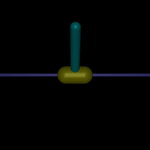
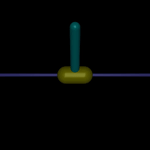
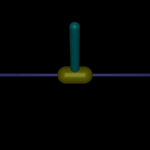
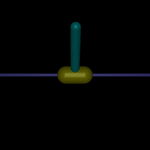
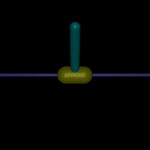
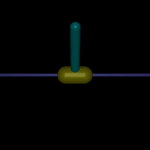
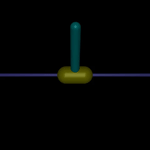
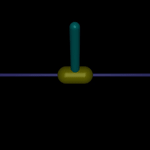
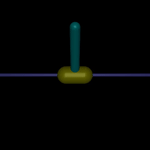

In [ ]:
env_name = 'InvertedPendulum-v4'
epochs = 100
lr = 0.003883
use_baseline = True
discount_factor = 0.9
dataset_length = 2500
demo_every_n_epochs = epochs//9

logger = pl.loggers.CSVLogger(env_name)
logger.log_hyperparams({'env_name': env_name, 'use_baseline': use_baseline, 'epochs': epochs, 'lr': lr, 'discount_factor': discount_factor, 'dataset_length': dataset_length, 'demo_every_n_epochs': demo_every_n_epochs})

dirpath = f'{env_name}/{logger.name}/version_{logger.version}'

env = Env(env_name=env_name)
agent = Agent(obs_dim=env.obs_dim, act_dim=env.act_dim, lr=lr, use_baseline=use_baseline)
on_policy_dataset = OnPolicyDataset(agent, env, use_advantage=use_baseline, dataset_length=dataset_length, discount_factor=discount_factor)

callbacks=[
    TQDMCb(),
    LoggerCb(logger),
    pl.callbacks.ModelCheckpoint(dirpath=dirpath, every_n_train_steps=demo_every_n_epochs, save_top_k=-1),
    DemoCb(env_name=env_name, dirpath=dirpath, every_n_epochs=demo_every_n_epochs),
]

trainer = pl.Trainer(accelerator='cpu',
                    logger=logger,
                    max_epochs=epochs,
                    callbacks=callbacks)

trainer.fit(agent, train_dataloaders=on_policy_dataset)

# Ploting

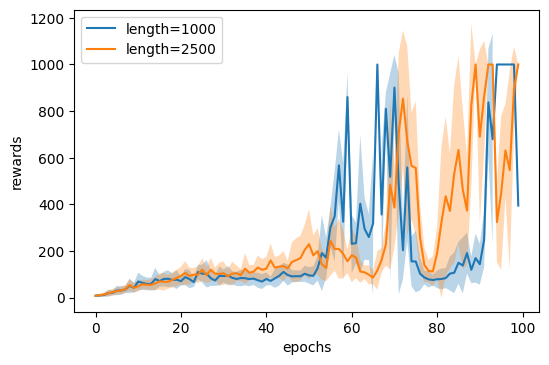

In [ ]:
log_folders = glob(f'{env_name}/**/*')
plt.figure(dpi=100)

for folder in log_folders:
  df = pd.read_csv(f'{folder}/metrics.csv')
  hyper_params = yaml.safe_load(open(f'{folder}/hparams.yaml'))

  rewards_mask = df.columns.str.contains('rewards/')
  rewards = df.iloc[:, rewards_mask]

  r_means = rewards.mean(axis=1)
  r_std = rewards.std(axis=1)

  plt.plot(r_means, label=f'length={hyper_params["dataset_length"]}')
  plt.fill_between(df.index, r_means - r_std, r_means + r_std, alpha=.3)

plt.xlabel('epochs')
plt.ylabel('rewards')
plt.legend(loc='upper left');